In [29]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

In [30]:
train_data_set = pd.read_csv("/home/mdirfan-code/projects/Sentimeter-v1.0/BERT_Model/Datasets/Training_dataset.csv")
train_data_set

,Unnamed: 0,sentiment,tweet_text
0,49647,Irrelevant,Last Weekend league for Fifa 20 Glad I could f...
1,43676,Positive,omg i'm so excited to watch dk play pubg
2,55915,Negative,all others who have problems with
3,14927,Positive,in
4,44039,Irrelevant,minho felix de jeongin sucked at pubg pretty h...
...,...,...,...
59191,37541,Negative,you
59192,6332,Neutral,I'm not even going to show a 7 2 loss.
59193,55392,Negative,Fuck this call of duty update..
59194,864,Positive,I should get up feed my dogs such that way whe...


In [31]:
test_data_set = pd.read_csv("/home/mdirfan-code/projects/Sentimeter-v1.0/BERT_Model/Datasets/Testing_dataset.csv")
test_data_set

,Unnamed: 0,sentiment,tweet_text
0,61413,Irrelevant,Looks to me like he failed to check out the wa...
1,44887,Irrelevant,Wow it takes all sorts of crazy people out the...
2,73662,Neutral,Nvidia Unveils The World s Fastest Gaming Moni...
3,36694,Neutral,Huge radio play here. Reinvention Corporate Ev...
4,2308,Negative,SO I HAPPY WHO ABOUT THIS.
...,...,...,...
14795,12630,Negative,where is all my Mamba Edition extras? I m bee...
14796,49615,Negative,Sell 700k fifa coins fucking this game
14797,12322,Negative,107 for a four game break and I can't even ev...
14798,4355,Irrelevant,has called me a madman.. I understood right fr...


In [32]:
test_data_set.drop('Unnamed: 0',axis=1,inplace=True)
test_data_set

,sentiment,tweet_text
0,Irrelevant,Looks to me like he failed to check out the wa...
1,Irrelevant,Wow it takes all sorts of crazy people out the...
2,Neutral,Nvidia Unveils The World s Fastest Gaming Moni...
3,Neutral,Huge radio play here. Reinvention Corporate Ev...
4,Negative,SO I HAPPY WHO ABOUT THIS.
...,...,...
14795,Negative,where is all my Mamba Edition extras? I m bee...
14796,Negative,Sell 700k fifa coins fucking this game
14797,Negative,107 for a four game break and I can't even ev...
14798,Irrelevant,has called me a madman.. I understood right fr...


In [33]:
train_data_set.drop(['Unnamed: 0'],axis=1,inplace=True)
train_data_set


,sentiment,tweet_text
0,Irrelevant,Last Weekend league for Fifa 20 Glad I could f...
1,Positive,omg i'm so excited to watch dk play pubg
2,Negative,all others who have problems with
3,Positive,in
4,Irrelevant,minho felix de jeongin sucked at pubg pretty h...
...,...,...
59191,Negative,you
59192,Neutral,I'm not even going to show a 7 2 loss.
59193,Negative,Fuck this call of duty update..
59194,Positive,I should get up feed my dogs such that way whe...


In [34]:
from sklearn.utils import class_weight

class_weights = list(class_weight.compute_class_weight('balanced', classes = np.unique(train_data_set['sentiment']) ,y=train_data_set['sentiment']))

In [35]:
class_weights

[1.4538756262894195,
 0.8231727667148737,
 1.0204095704337033,
 0.8949564586357039]

In [36]:
class_weights.sort()
np.unique(train_data_set['sentiment'])

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [37]:
weights = {}
for index, weight in enumerate(class_weights):
    weights[index] = weight
weights


{0: 0.8231727667148737,
 1: 0.8949564586357039,
 2: 1.0204095704337033,
 3: 1.4538756262894195}

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_set['tweet_text'].values,train_data_set['sentiment'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_set['tweet_text'].values,test_data_set['sentiment'].values))

In [39]:
train_data_set['sentiment'].value_counts()

Negative      17978
Positive      16536
Neutral       14503
Irrelevant    10179
Name: sentiment, dtype: int64

In [40]:
table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys = tf.constant([ 'Negative','Positive', 'Neutral', 'Irrelevant']),
        values=tf.constant([0,1,2,3])
    ),
    default_value=tf.constant(-1),
    name = "target_encoding"
)

@tf.function
def target(x):
    return table.lookup(x)
    

In [41]:
def show_batch(dataset, size=5):
    for batch, label in dataset.take(size):
        print(batch.numpy())
        print(target(label).numpy())

In [42]:
show_batch(train_dataset,6)

b'Last Weekend league for Fifa 20 Glad I could finish strong . . Birthday Mbappe and TOTS de Bruyne were absolutely clutch . pic.twitter.com n1766sVgP9'
3
b"omg i'm so excited to watch dk play pubg"
1
b'all others who have problems with'
0
b'in'
1
b"minho felix de jeongin sucked at pubg pretty hard today I'm just.. I'm less different than them at 1 thing"
3
b"I appreciate any advice suggestions on this pleeeeease if it's doing hot noodle canister in! All game action was smooth before. This choppy capture is not good. It was fine capturing in OBS before the Nvidia driver update for my RTX GPUs already NERDIOD help NEEDED! "
0


In [43]:
def fetch(text, labels):
    return text, tf.one_hot(target(labels),4)

In [44]:
train_data_f = train_dataset.map(fetch)
test_data_f = test_dataset.map(fetch)
next(iter(train_data_f))

(<tf.Tensor: shape=(), dtype=string, numpy=b'Last Weekend league for Fifa 20 Glad I could finish strong . . Birthday Mbappe and TOTS de Bruyne were absolutely clutch . pic.twitter.com n1766sVgP9'>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 1.], dtype=float32)>)

In [45]:
train_data, train_labels = next(iter(train_data_f.batch(5)))
train_data, train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Last Weekend league for Fifa 20 Glad I could finish strong . . Birthday Mbappe and TOTS de Bruyne were absolutely clutch . pic.twitter.com n1766sVgP9',
        b"omg i'm so excited to watch dk play pubg",
        b'all others who have problems with', b'in',
        b"minho felix de jeongin sucked at pubg pretty hard today I'm just.. I'm less different than them at 1 thing"],
       dtype=object)>,
 <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
 array([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]], dtype=float32)>)

In [46]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_data_f = train_data_f.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data_f = test_data_f.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [47]:
for example, label in train_data_f.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"Go see my boy he's the best!"
 b'W Come help make an OTK Priest tonight at 9 30pm MST. It is going to be a ton of fun! Don t miss out!. twitch.tv HellsF1rst. . fb.me e fj0rQWF02. . '
 b'i m dying someone at a depot screamed IF YOU AINT FROM AMERICA GET THE FUCK OUT u u know something crazy... he was right']

labels:  [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [48]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_data_f.map(lambda text, label:text))

In [49]:
vocab = np.array(encoder.get_vocabulary())
vocab[:12]

array(['', '[UNK]', 'the', 'i', 'to', 'and', 'a', 'of', 'is', 'for', 'in',
       'this'], dtype='<U19')

In [50]:
example = ["this is my game", "I love Myself more than anything","why me nivea"]
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   8,  15,  18,   0,   0],
       [  3,  58, 491,  63, 132, 370],
       [ 71,  20,   1,   0,   0,   0]])

In [51]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=1000,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')
])


In [52]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [53]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(train_data_f.take(1))
print(predictions[0])

[0.25128746 0.24878749 0.24901822 0.2509068 ]


In [54]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 101,444
Trainable params: 101,444
Non-trainable params: 0
________________________________________________

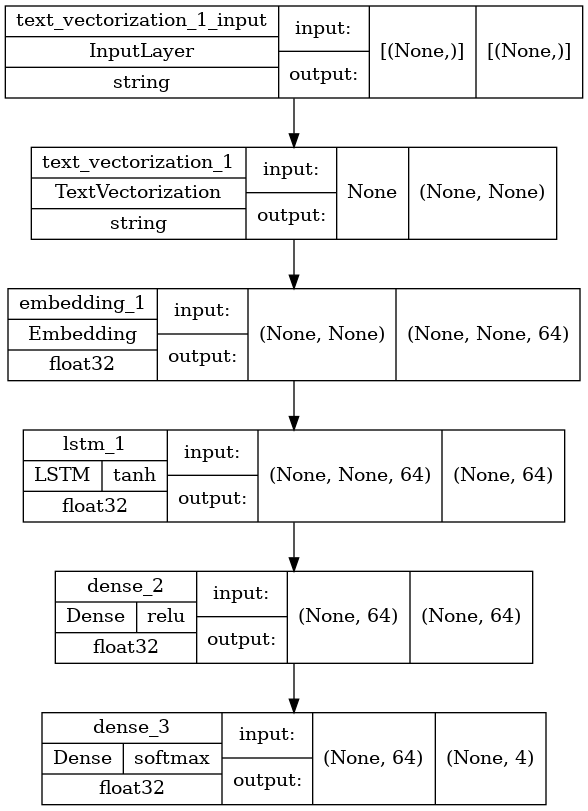

In [56]:
model_img_file = 'Unidirection_LSTM.png'
tf.keras.utils.plot_model(model, to_file=model_img_file, 
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_dtype=True,
                          show_layer_names=True )

In [57]:
history = model.fit(train_data_f,epochs=25,validation_data=test_data_f,verbose=1,class_weight=weights)

# model.summary()

Epoch 1/25


/home/mdirfan-code/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


925/925 [==============================] - 60s 56ms/step - loss: 1.3065 - accuracy: 0.4249 - val_loss: 1.1807 - val_accuracy: 0.5243
Epoch 2/25
925/925 [==============================] - 53s 56ms/step - loss: 1.1203 - accuracy: 0.5563 - val_loss: 1.0786 - val_accuracy: 0.5629
Epoch 3/25
925/925 [==============================] - 53s 57ms/step - loss: 1.0443 - accuracy: 0.5815 - val_loss: 1.0404 - val_accuracy: 0.5748
Epoch 4/25
925/925 [==============================] - 56s 59ms/step - loss: 1.0053 - accuracy: 0.5935 - val_loss: 1.0200 - val_accuracy: 0.5843
Epoch 5/25
925/925 [==============================] - 54s 57ms/step - loss: 0.9846 - accuracy: 0.6002 - val_loss: 1.0224 - val_accuracy: 0.5762
Epoch 6/25
925/925 [==============================] - 54s 57ms/step - loss: 0.9705 - accuracy: 0.6057 - val_loss: 1.0165 - val_accuracy: 0.5787
Epoch 7/25
925/925 [==============================] - 54s 57ms/step - loss: 0.9609 - accuracy: 0.6088 - val_loss: 1.0034 - val_accuracy: 0.5872
Epo

In [58]:
classes = [ 'Negative','Positive', 'Neutral', 'Irrelevant']


In [59]:
classes[model.predict(np.array(["omg i'm so excited to watch dk play pubg"])).argmax()]

'Positive'

In [60]:

classes[model.predict(np.array(["The worse game I've played in the last few years is  Dead  "])).argmax()]

'Negative'

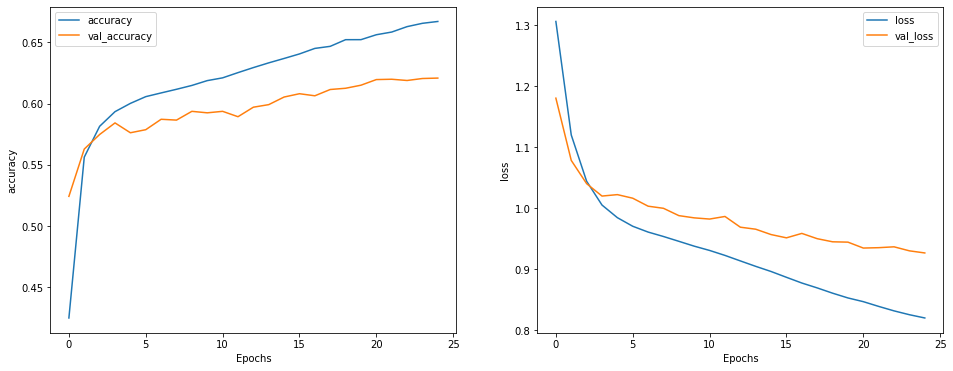

In [61]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')